# Предсказание наличия порока сердца с использованием модели машинного обучения

В этом блокноте мы построим модель, способную предсказывать вероятность наличия порока сердца у пациентов на основе медецинских показателей.

## 1. Определение задачи

> Дан набор клинических показателей пациента. Необходимо определить, имеет ли пациент порок сердца?

## 2. Данные

Тренировка и проверка модели произведена на основе данных, взятых с UCI Machine Learning Repository. 
https://archive.ics.uci.edu/ml/datasets/heart+disease

## 3. Оценка качества

> будем считать проект удачным, если сможем достичь 95% точности предсказания наличия либо отсутствия заболевания

## 4. Особенности

**Описание данных:**

* age age in years
* sex (1 = male; 0 = female)
* cp: chest pain type (4 values)
    - 0: typical angina 
    - 1: atypical angina 
    - 2: non-anginal pain 
    - 3: asymptomatic 
* resting blood pressure (in mm Hg on admission to the hospital)
* serum cholestoral in mg/dl 
* fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
* resting electrocardiographic results (values 0,1,2)
* thalach - maximum heart rate achieved 
* exercise induced angina (1 = yes; 0 = no)
* oldpeak = ST depression induced by exercise relative to rest 
* slope: the slope of the peak exercise ST segment 
    * 1: upsloping 
    * 2: flat 
    * 3: downsloping 
* number of major vessels (0-3) colored by flourosopy 
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
* target 1 or 0

Будем использовать только 14 атрибутов:
1. #3 (age) 
2. #4 (sex) 
3. #9 (cp) 
4. #10 (trestbps) 
5. #12 (chol) 
6. #16 (fbs) 
7. #19 (restecg) 
8. #32 (thalach) 
9. #38 (exang) 
10. #40 (oldpeak) 
11. #41 (slope) 
12. #44 (ca) 
13. #51 (thal) 
14. #58 (num) (the predicted attribute) 


## Импорт инструментов

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Делаем диаграммы и графики доступными внутри блокнота
%matplotlib inline 

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

## Загрузка данных

In [3]:
df = pd.read_csv("heart-disease.csv")
df.shape 

(303, 14)

## Разведочный анализ данных (EDA)

Попытаемся лучше понять датасет и саму суть вопроса.

1. What quastion(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. Wat's missing from the data and how do you deal with it?
4. where are the outliers and why should you care about them?
5. Haw can you add, change or remove features to get more out of your data?

In [142]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [143]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [4]:
# Выясняем, сколько экземпляров кадого из классов в нашем наборе:
df["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

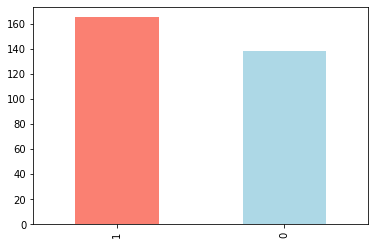

In [5]:
df["target"].value_counts().plot(kind='bar', color=["salmon", "lightblue"]);

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
# Проверяем на наличие пустых ячеек:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Частота заболевания в зависимости от пола пациента

In [11]:
# Количество полов (0 - женский,1 - мужской):
df.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

In [12]:
# Сравним столбцы цели и пола

pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,24,114
1,72,93


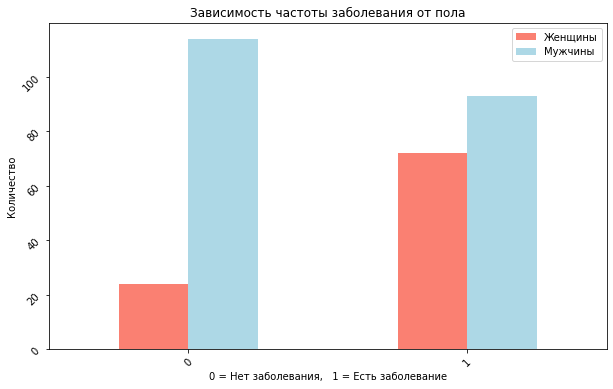

In [15]:
# Представим на графике:
pd.crosstab(df.target, df.sex).plot(kind='bar', 
                                    figsize=(10, 6),
                                    color=['salmon', 'lightblue'])
plt.title("Зависимость частоты заболевания от пола")
plt.xlabel("0 = Нет заболевания,   1 = Есть заболевание")
plt.ylabel('Количество')
plt.legend(['Женщины', 'Мужчины']);
plt.xticks(rotation=45);
plt.yticks(rotation=45);

In [16]:
df['thalach'].value_counts()

162    11
160     9
163     9
173     8
152     8
       ..
129     1
128     1
127     1
124     1
71      1
Name: thalach, Length: 91, dtype: int64

### Взаимосвязь возраста и максимального пульса с заболеванием

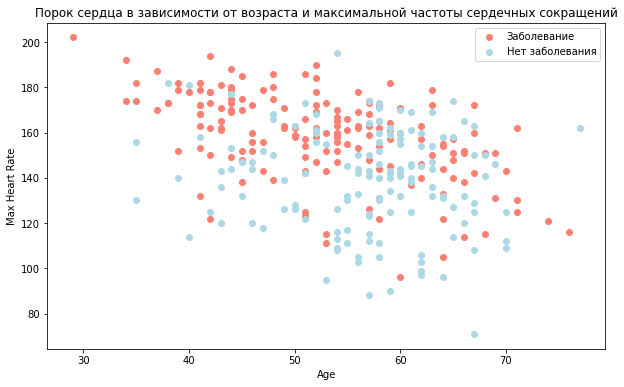

In [17]:
plt.figure(figsize=(10, 6))

# Разброс с положительными результатами
plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
            c='salmon')

# Разброс с отрицательными результатами
plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            c='lightblue')

# Инфо
plt.title("Порок сердца в зависимости от возраста и максимальной частоты сердечных сокращений")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Заболевание", "Нет заболевания"]);

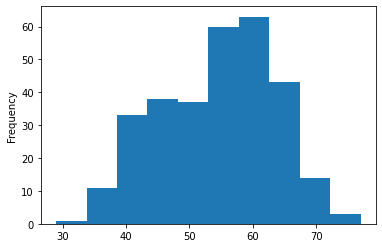

In [20]:
# Распределение колонки возрастов.

# общее:
df.age.plot.hist();

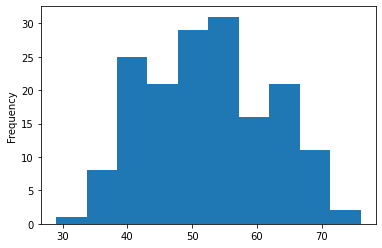

In [21]:
# С заболеванием:
df.age[df.target==1].plot.hist();

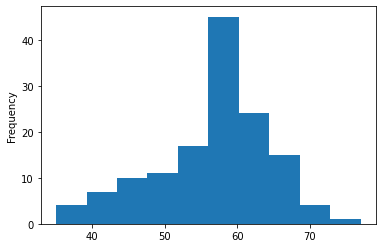

In [22]:
# без заболевания:
df.age[df.target==0].plot.hist();

### Частота заболеаний в зависимости от типа боли в груди (Chest Pain Type)

cp: chest pain type (4 values)
   * 0: typical angina 
   * 1: atypical angina 
   * 2: non-anginal pain 
   * 3: asymptomatic 

In [23]:
pd.crosstab(df.cp, df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


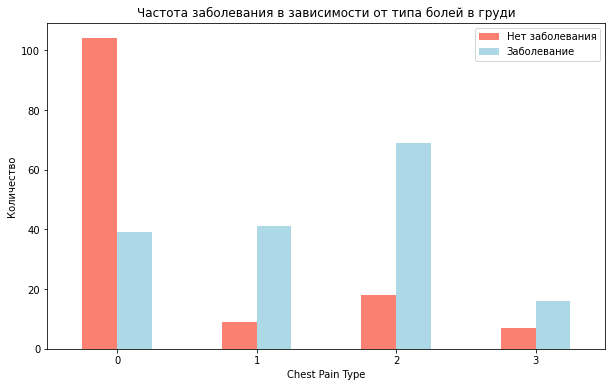

In [24]:
# Визуализируем кросстаб
pd.crosstab(df.cp, df.target).plot(kind="bar", 
                                   figsize=(10, 6),
                                   color=['salmon', 'lightblue'])

# Описание
plt.title('Частота заболевания в зависимости от типа болей в груди')
plt.xlabel('Chest Pain Type')
plt.ylabel('Количество')
plt.legend(['Нет заболевания', 'Заболевание'])
plt.xticks(rotation=0);

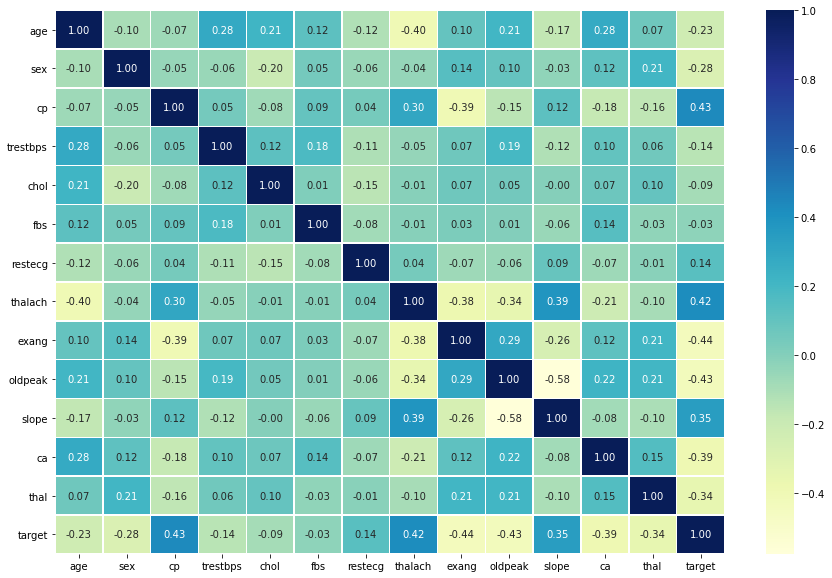

In [26]:
# Построим корреляционную матрицу
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt='.2f',
                 cmap='YlGnBu')

## 5.1 Построение модели

In [27]:
# Отделим атрибуты (X) и лейблы (y)
X = df.drop('target', axis=1)
y = df['target']

In [28]:
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [29]:
# Разделим данные на тренировочный и тестовый наборы
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

Попробуем три разных модели машинного обучения:
1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. RandomForestClassifier

In [31]:
models = {'Logistic Regression': LogisticRegression(),
          'KNN': KNeighborsClassifier(),
          'Random Forest': RandomForestClassifier()}

# Функция для тртенировки и оценки моделей
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Тренирует и оценивает заданные модели.
    models : словарь из моделей Scikit-Learn
    X_train : тренировочные данные (no labels)
    X_test : проверочные данные (no labels)
    y_train : тренировочные лейблы
    y_test : проверочные лейблы
    """
    np.random.seed(42)
    # Словарь для хранения результативности моделей
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [33]:
model_scores = fit_and_score(models=models, 
                             X_train=X_train, 
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

/Users/user/ML_Projects/heart-disease-project/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918}

### Сравнение моделей

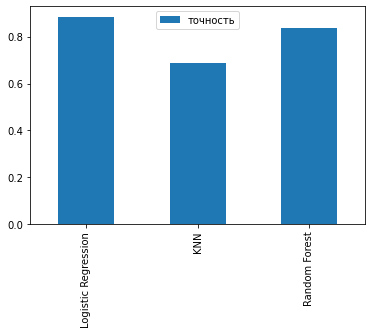

In [34]:
model_compare = pd.DataFrame(model_scores, index=['точность'])
model_compare.T.plot.bar();


Попробуем донастроить модели

Что можно попробовать:
* Hyperparameter tuning
* Feature importance
* Confusing matrix
* Cross-validation
* Precision
* Recall
* F1 score
* Classification report
* ROC Curve
* Area under the curve (AUC)

## Hyperparameter tuning

In [35]:
# Попробуем настроить KNN

train_scores = []
test_scores = []

# Создадим список с разными значениями n-neighbors 

neighbors = range(1, 21)

# Создадим экземпляр KNN

knn = KNeighborsClassifier()

# Проверим с разными значениями n_neighbors

for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    # тренировка
    knn.fit(X_train, y_train)
    
    # Добавим значение в список тренировочных результатов
    train_scores.append(knn.score(X_train, y_train))
    
    # Добавим значение в список тестовых результатов
    test_scores.append(knn.score(X_test, y_test))
    

In [36]:
train_scores

[1.0,
 0.8099173553719008,
 0.7727272727272727,
 0.743801652892562,
 0.7603305785123967,
 0.7520661157024794,
 0.743801652892562,
 0.7231404958677686,
 0.71900826446281,
 0.6942148760330579,
 0.7272727272727273,
 0.6983471074380165,
 0.6900826446280992,
 0.6942148760330579,
 0.6859504132231405,
 0.6735537190082644,
 0.6859504132231405,
 0.6652892561983471,
 0.6818181818181818,
 0.6694214876033058]

In [37]:
test_scores

[0.6229508196721312,
 0.639344262295082,
 0.6557377049180327,
 0.6721311475409836,
 0.6885245901639344,
 0.7213114754098361,
 0.7049180327868853,
 0.6885245901639344,
 0.6885245901639344,
 0.7049180327868853,
 0.7540983606557377,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.6885245901639344,
 0.7213114754098361,
 0.6885245901639344,
 0.6885245901639344,
 0.7049180327868853,
 0.6557377049180327]

Максимальная оценка KNNна тестовых данных: 75.41%


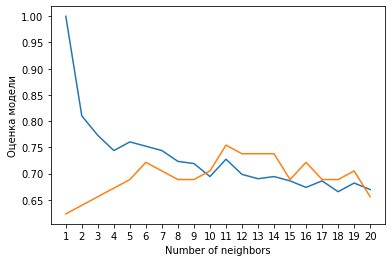

In [38]:
plt.plot(neighbors, train_scores, label='Train score')
plt.plot(neighbors, test_scores, label='Test score')
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Оценка модели")
plt.legend

print(f"Максимальная оценка KNNна тестовых данных: {max(test_scores)*100:.2f}%")

## Hyperparameter tuning с использованием RandomizedSearchCV

Используя RandomizedSearchCV попробуем настроить:
* Logistic Regression()
* RandomForestClassifier()

In [39]:
# Создадим сетку hyperparameter'ов для LogisticRegression

log_reg_grid = {"C": np.logspace(-4, 4, 20),
           "solver": ["liblinear"]}

# Создадим сетку hyperparameter'ов для RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 1)}

Имея сетки параметров для каждой из моделей попробуем найти оптимальные настройки используя функцию RandomizedSearchCV

In [40]:
# Настроим LogisticRegression

np.random.seed(42)

# Настраиваем случайный поиск параметров для LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Тренируем LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [41]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [45]:
# Оценим модель:
rs_log_reg.score(X_test, y_test)

0.8852459016393442

Сделаем то же самое для RandomForestClassifier().

In [43]:
np.random.seed(42)

# Настроим поиск параметров для RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# тренируем RandomForestClassifier()...
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   47.0s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [44]:
# Лучший набор:
rs_rf.best_params_

{'n_estimators': 10,
 'min_samples_split': 16,
 'min_samples_leaf': 5,
 'max_depth': None}

In [46]:
# Оценим результат для RandomForestClassifier:
rs_rf.score(X_test, y_test)

0.8688524590163934

## Настройка параметров с GridSearchCV

Поскольку модель на основе LogisticRegression показала наилучшие результаты, попробуем еще улучшить их с помощью GridSearchSV...

In [47]:
# Создаем сетку для поиска параметров для LogisticRegression

log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# тренируем модель
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.6s finished


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [48]:
# ЛУчший набор:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [49]:
# Оценим результаты:
gs_log_reg.score(X_test, y_test)

0.8852459016393442

In [50]:
model_scores

{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918}

## Другие параметры оценки нашей модели

* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1 score

In [51]:
# Сделаем предсказания
y_preds = gs_log_reg.predict(X_test)
y_preds

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

In [52]:
y_test

179    0
228    0
111    1
246    0
60     1
      ..
249    0
104    1
300    0
193    0
184    0
Name: target, Length: 61, dtype: int64

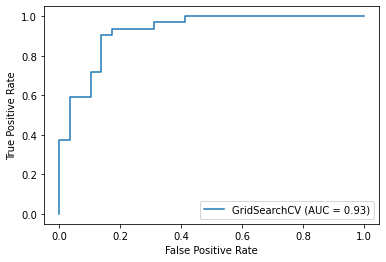

In [55]:
# Выведем кривую ROC и вычислим AUC
plot_roc_curve(gs_log_reg, X_test, y_test);

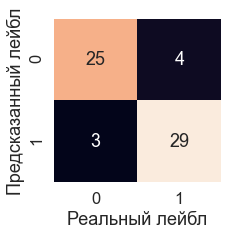

In [62]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Симпатично выводит confusion matrix с использованием Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("Реальный лейбл")
    plt.ylabel("Предсказанный лейбл")

plot_conf_mat(y_test, y_preds)

Посмотрим на классификационный отчет.

In [63]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



### Рассчитаем метрики оценки с помощью `cross-val_score()`

In [64]:
# Лучшие параметры
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [66]:
# Создаем новый классификатор с оптимальными параметрами
clf = LogisticRegression(C=0.20433597178569418,
                         solver="liblinear")

In [67]:
# Cross-validated accuracy
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")
cv_acc

array([0.81967213, 0.90163934, 0.86885246, 0.88333333, 0.75      ])

In [68]:
# Среднее значение
cv_acc = np.mean(cv_acc)
cv_acc

0.8446994535519124

In [69]:
# Cross-validated precision
cv_precision = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="precision")
cv_precision

array([0.775     , 0.88571429, 0.85714286, 0.86111111, 0.725     ])

In [70]:
# Среднее значение
cv_precision = np.mean(cv_precision)
cv_precision

0.8207936507936507

In [71]:
# Cross-validated recall
cv_recall= cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="recall")
cv_recall

array([0.93939394, 0.93939394, 0.90909091, 0.93939394, 0.87878788])

In [72]:
# Среднее значение
cv_recall = np.mean(cv_recall)
cv_recall

0.9212121212121213

In [73]:
# Cross-validated f1-score
cv_f1= cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="f1")
cv_f1

array([0.84931507, 0.91176471, 0.88235294, 0.89855072, 0.79452055])

In [74]:
# Среднее значение
cv_f1 = np.mean(cv_f1)
cv_f1

0.8673007976269721

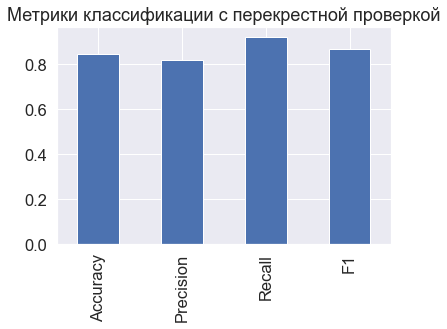

In [75]:
# Визуализируем наши метрики
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1},
                          index=[0])
cv_metrics.T.plot.bar(title="Метрики классификации с перекрестной проверкой",
                      legend=False);

### Значимость параметров

Постараемся понять, какие показатели (поля в датасете) больше всего повлияли на результаты модели и как?

In [76]:
# Натренируем экземпляр LogisticRegression
gs_log_reg.best_params_

clf = LogisticRegression(C=0.20433597178569418,
                         solver="liblinear")
clf.fit(X_train, y_train);

In [77]:
# Выведем coef_
clf.coef_

array([[ 0.00316727, -0.86044582,  0.66067073, -0.01156993, -0.00166374,
         0.04386131,  0.31275787,  0.02459361, -0.60413038, -0.56862852,
         0.45051617, -0.63609863, -0.67663375]])

In [78]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


`coef_` показывает, как каждый параметр (переменная, столбец) влияет на целевую метку.

In [79]:
# Сопоставим значения coef названиям столбцов
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': 0.0031672721856887734,
 'sex': -0.860445816920919,
 'cp': 0.6606707303492849,
 'trestbps': -0.011569930902919925,
 'chol': -0.001663741604035976,
 'fbs': 0.04386130751482091,
 'restecg': 0.3127578715206996,
 'thalach': 0.02459360818122666,
 'exang': -0.6041303799858143,
 'oldpeak': -0.5686285194546157,
 'slope': 0.4505161679452401,
 'ca': -0.6360986316921434,
 'thal': -0.6766337521354281}

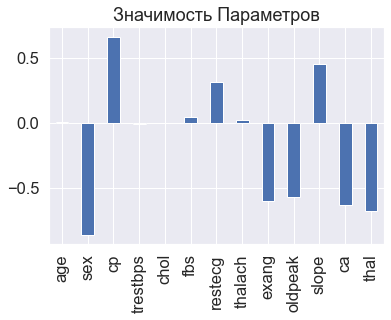

In [80]:
# Визуализируем значимость параметров
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title='Значимость Параметров', legend=False);

In [81]:
pd.crosstab(df["sex"], df["target"])

target,0,1
sex,,
0,24,72
1,114,93


In [82]:
print(f'соотношение для \"1\": {72/24:.2f}'),
print(f'соотношение для \"0\": {93/114:.2f}')

соотношение для "1": 3.00
соотношение для "0": 0.82


Это обозначает, что чем выше параметр 'sex' (1 - М, 0 - Ж ), тем ниже вероятность возникновения порока сердца.

In [83]:
pd.crosstab(df["slope"], df["target"])

target,0,1
slope,,
0,12,9
1,91,49
2,35,107


In [84]:
9/12, 49/91, 107/35

(0.75, 0.5384615384615384, 3.057142857142857)

slope: the slope of the peak exercise ST segment
- 0: upsloping: better heart rate with exersize (uncommon)
- 1: flat: minimal change (typical healthy heart)
- 2: downsloping: signs of unhealthy heart

## 6. Как улучшить результат

На данном этапе не удалось достигнуть желаемой точноти в 95%.
Пути решения: 
* более интеллектуальный анализ данных. В идеале обсуждение со специалистами в данной области самых значимых параметров(возможно, исключить поле 'sex' из анализа?). Либо изменение индексации их значения (поменять местами значения '0' и '1' для 'slope'?)
* Попробовать другую модель